# Fast Gradient Sign Method (FGSM) against ResNet-50 on CIFAR-10

In summary, the ResNet-50 pretrained on ImageNet is fine-tuned for CIFAR-10 dataset. The robustness of this fine-tuned model is then tested against adversarial examples generated by the FGSM attack.

## Importing Libraries

Let's import all the libraries required to run this project.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import random

## Loading the Dataset

Next, we’ll write a function that is responsible for loading the CIFAR-10 dataset, preprocessing the data, and setting up the train and test dataloaders.

The function defines a tuple of classes names corresponding to the 10 classes in the CIFAR-10 dataset, and returns the train and test sets, their respective data loaders and classes.

In [2]:
def load_dataset(batch_size):
    # Set dataset path
    dataset_path = './data/cifar10'

    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    # Load CIFAR-10 dataset
    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True,
                                            download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False,
                                           download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                             shuffle=False, num_workers=2)

    # Class names for CIFAR-10 dataset
    classes = ('plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck')

    return trainset, trainloader, testset, testloader, classes


## Training the Model

Once the datasets are loaded and dataloaders are initialized, we can proceed to train the model.

The “train” function is responsible for training the model on the CIFAR-10 dataset. The function performs the training loop for one epoch and returns the updated model parameters, training loss, and training accuracy. It initializes some variables to keep track of the loss and accuracy.

In [3]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # Switch to train mode
    model.train()

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item() * inputs.size(0)

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Compute average training loss and accuracy
    train_loss = train_loss / len(trainloader.dataset)
    train_accuracy = 100.0 * train_correct / train_total

    return model, train_loss, train_accuracy

## Testing the Model

The “test” function evaluates the model on the test set and returns the test loss and accuracy.

In [4]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item() * inputs.size(0)

            # Compute test accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    # Compute average test loss and accuracy
    test_loss = test_loss / len(testloader.dataset)
    test_accuracy = 100.0 * test_correct / test_total

    return test_loss, test_accuracy

## Iterating the Training

The “train_epochs” function trains the model for specified number of epochs and saves the best performing model. It returns the lists of losses and accuracies for train, and validation sets, which can be used to visualize the training and validation progress and evaluate the performance of the model. This can be used to decide when to stop training, and adjust the hyper-parameters like learning rate, batch size, etc.

In [5]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs, save_interval=5):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        model, train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}%')
        print(f'Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')
        print()

        # Save the model if the current test accuracy is higher than the best accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            checkpoint = {
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                #'optimizer_state_dict': optimizer.state_dict(),
                'test_accuracy' : test_accuracy
            }
            torch.save(checkpoint, 'best_model.pth')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

## Core of FGSM
FGSM_attack function takes clean images as input, calculates the loss with respect to the image, calculates the gradients its sign to compute the perturbation, and finally adds the perturbation to the clean image to generate an adversarial example.

Here's exactly what's happening:

1. The requires_grad attribute of images is set to True so that the gradients of the loss function are tracked with respect to the images.

2. A forward pass through the model is performed to obtain the model outputs.

3. The loss between model outputs and true labels is computed.

4. Gradients are cleared to avoid the accumulation of gradients over multiple iterations.

5. Backward propogation takes place to compute gradients of the loss function with respect to the images.

6. From the grad attribute of images, we retrieve the gradients.

7. The gradients are multiplied by epsilon, taking the sign of the result. This gives the direction of the perturbation to be applied to the images.

8. The adversarial example is generated by adding the perturbation to clean images.

9. The images are clipped to the range [0, 1] to ensure that the perturbed images are stil valid images.

10. Finally, we return the perturbed images and the perturbations that were applied to them.



In [6]:
def fgsm_attack(model, criterion, images, labels, device, epsilon):
    images.requires_grad_(True)
    outputs = model(images)
    loss = criterion(outputs, labels).to(device)
    model.zero_grad()
    loss.backward()

    gradient = images.grad.data
    perturbations = epsilon * torch.sign(gradient)
    adversarial_images = images + perturbations
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images, perturbations

## Testing Robustness of ResNet-50 against FGSM

The code below tests the accuracy of the fine-tuned ResNet-50 model against adversarial examples generated by FGSM.

* Adversarial Accuracy is defined by the percentage of images correctly classified by the model. This is a measure of the robustness of the model against the attack.
* Attack Success Rate is measured as the percentage of
adversarial images that are misclassified, among benign inputs that are correctly classified by the model. This is a measure of robustness of the attack against the model.

In [7]:
def test_adversarial(model, testloader, criterion, device, epsilon):
    adversarial_correct = 0
    attack_success = 0
    total = 0

    model.eval()

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        adversarial_images, _ = fgsm_attack(model, criterion, images, labels, device, epsilon)

        adversarial_outputs = model(adversarial_images)

        _, adversarial_predicted = torch.max(adversarial_outputs.data, 1)

        adversarial_correct += (adversarial_predicted == labels).sum().item()
        attack_success += (adversarial_predicted != labels).sum().item()
        total += labels.size(0)

    adversarial_accuracy = 100.0 * adversarial_correct / total
    attack_success_rate = 100.0 * attack_success / total

    print(f'Adversarial Accuracy: {adversarial_accuracy:.2f}%')
    print(f'Attack Success Rate: {attack_success_rate:.2f}%')

## Visualizing the Results

In [8]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()


def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)), train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)), test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy_plot.png')
    plt.show()

In [9]:
def plot_image(dataset, model, classes, device):
    idx = random.randint(0, len(dataset))
    label = dataset[idx][1]
    img = dataset[idx][0].unsqueeze(0).to(device)  # Move the input image tensor to the GPU
    model.eval()
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    # Convert the image and show it
    img = img.squeeze().permute(1, 2, 0).cpu()  # Move the image tensor back to the CPU and adjust dimensions
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {classes[predicted]}, True: {classes[label]}')
    plt.savefig('predicted_image.png')
    plt.show()
    print("Predicted label: ", classes[predicted[0].item()])
    print("Actual label: ", classes[label])

In [10]:
def plot_adv_images(dataset, model, criterion, classes, device, epsilon):
    num_images = 4

    clean_images = []
    clean_labels = []
    for _ in range(num_images):
        index = random.randint(0, len(dataset))
        image, label = dataset[index]
        clean_images.append(image)
        clean_labels.append(label)

    clean_images = torch.stack(clean_images).to(device)
    clean_labels = torch.tensor(clean_labels).to(device)

    adversarial_images, perturbations = fgsm_attack(model, criterion, clean_images, clean_labels, device, epsilon)

    fig, axes = plt.subplots(num_images, 5, figsize=(15, 10))

    for i in range(num_images):
        clean_img = clean_images[i].cpu().permute(1, 2, 0).detach().numpy()
        perturbation = perturbations[i].cpu().permute(1, 2, 0).detach().numpy()
        adversarial_img = adversarial_images[i].cpu().permute(1, 2, 0).detach().numpy()

        axes[i, 0].imshow(clean_img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Clean: {classes[clean_labels[i]]}', fontweight='bold', color='green')

        axes[i, 1].axis('off')
        axes[i, 1].text(0.5, 0.5, '+', fontsize=40, ha='center', va='center')
        axes[i, 1].set_title('')

        axes[i, 2].imshow(perturbation)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Perturbation')

        axes[i, 3].axis('off')
        axes[i, 3].text(0.5, 0.5, '=', fontsize=40, ha='center', va='center')
        axes[i, 3].set_title('')

        axes[i, 4].imshow(adversarial_img)
        axes[i, 4].axis('off')
        axes[i, 4].set_title(f'Adversarial: {classes[model(adversarial_images[i].unsqueeze(0)).argmax().item()]}', fontweight='bold', color='red')

    plt.tight_layout()
    plt.title('Results of Generated Adversarial Examples')
    plt.savefig('Generated_Adversarial_examples.png')
    plt.show()


## Flow of Code

The seed is set for reproducibility. The dataset and model are loaded. The model's first convolutional layer is modified to suit CIFAR-10 dataset such that there is lesser loss of spatial information. The fully connected layer is also modified to suit CIFAR-10's 10 classes.

The loss function is CrossEntropy, optimizer is Stochastic Gradient Descent with a learning rate of 0.001, momentum of 0.9, epoch=. The size of perturbation is set to 0.3.

First the model is trained and the accuracy is calculated on the clean test set.
Then the best model saved is loaded and tested against the adversarial examples. Finally, the adversarial examples are visualized.

In [11]:
def main(train_model):

    # Set random seeds for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    # Load the dataset
    num_classes = 10
    batch_size = 64
    trainset, trainloader, testset, testloader, classes = load_dataset(batch_size)

    # Load the pre-trained model
    model = models.resnet50(pretrained=True)
    # Modify conv1 to suit CIFAR-10
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    # Modify the final fully connected layer according to the number of classes
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Set hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    num_epochs = 60
    epsilon = 0.3

    if train_model:
      print("Training the model...")
      # Train the model
      model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
          model, trainloader, testloader, criterion, optimizer, device, num_epochs)

      # Plot the loss and accuracy curves
      plot_loss(train_losses, test_losses)
      plot_accuracy(train_accuracies, test_accuracies)
      # Plot and save an example image
      plot_image(testset, model, classes, device)
    else:
      print("Testing with adversarial examples...")
      # Load the best model
      best_model = models.resnet50(pretrained=True)
      # Modify conv1 to suit CIFAR-10
      best_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
      best_model.fc = nn.Linear(num_features, num_classes)
      checkpoint = torch.load('best_model.pth')
      best_model.load_state_dict(checkpoint['model_state_dict'])
      epoch = checkpoint['epoch']
      test_accuracy = checkpoint['test_accuracy']
      best_model = best_model.to(device)
      print("Best Trained Model Loaded!")
      print(f"Checkpoint at Epoch {epoch+1} with accuracy of {test_accuracy}")

      # Test the best model on adversarial examples
      print(f"Best_model at ...")
      test_adversarial(best_model, testloader, criterion, device, epsilon)

      # Visualize some adversarial examples
      print("Generating Visualization Plot")
      plot_adv_images(testset, best_model, criterion, classes, device, epsilon)

## The Main Function

The main() function is the entry point for the program.

If train_model is set to True, the function trains the model. The function first trains the model for num_epochs epochs. After each epoch, the function plots the loss and accuracy curves. The function then plots and saves an example image.

If train_model is set to False, the function loads the best model from a checkpoint. The function then tests the best model on adversarial examples. The function also visualizes some adversarial examples.

100%|██████████| 170498071/170498071 [00:03<00:00, 47617552.79it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10
Files already downloaded and verified


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 268MB/s]


Training the model...
Epoch 1/60
Train Loss: 1.3202 - Train Accuracy: 52.65%
Test Loss: 0.8234 - Test Accuracy: 70.49%

Epoch 2/60
Train Loss: 0.7391 - Train Accuracy: 74.48%
Test Loss: 0.5847 - Test Accuracy: 79.81%

Epoch 3/60
Train Loss: 0.5422 - Train Accuracy: 81.18%
Test Loss: 0.4688 - Test Accuracy: 84.22%

Epoch 4/60
Train Loss: 0.4438 - Train Accuracy: 84.59%
Test Loss: 0.4038 - Test Accuracy: 86.12%

Epoch 5/60
Train Loss: 0.3750 - Train Accuracy: 86.86%
Test Loss: 0.3744 - Test Accuracy: 87.32%

Epoch 6/60
Train Loss: 0.3228 - Train Accuracy: 88.77%
Test Loss: 0.3516 - Test Accuracy: 87.92%

Epoch 7/60
Train Loss: 0.2830 - Train Accuracy: 90.17%
Test Loss: 0.3370 - Test Accuracy: 88.72%

Epoch 8/60
Train Loss: 0.2424 - Train Accuracy: 91.60%
Test Loss: 0.3457 - Test Accuracy: 88.49%

Epoch 9/60
Train Loss: 0.2213 - Train Accuracy: 92.36%
Test Loss: 0.3296 - Test Accuracy: 89.31%

Epoch 10/60
Train Loss: 0.1973 - Train Accuracy: 93.06%
Test Loss: 0.3149 - Test Accuracy: 89.81

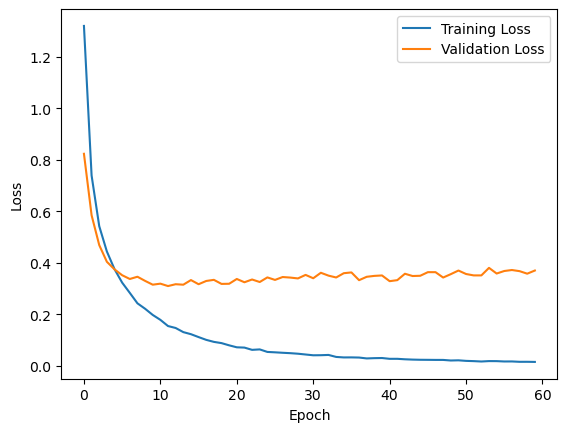

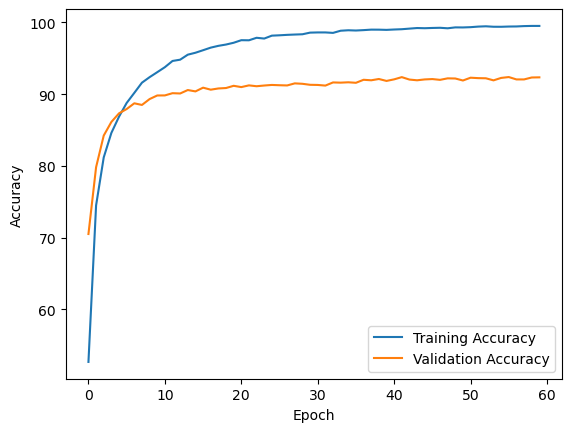

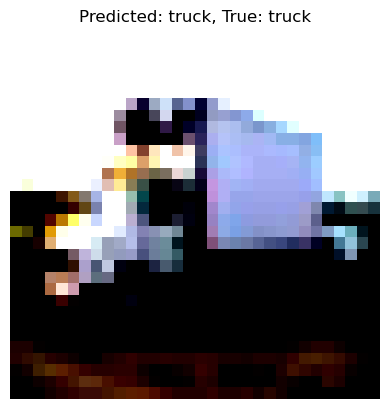

Predicted label:  truck
Actual label:  truck
Files already downloaded and verified
Files already downloaded and verified
Testing with adversarial examples...
Best Trained Model Loaded!
Checkpoint at Epoch 56 with accuracy of 92.38
Best_model at ...
Adversarial Accuracy: 29.25%
Attack Success Rate: 70.75%
Generating Visualization Plot


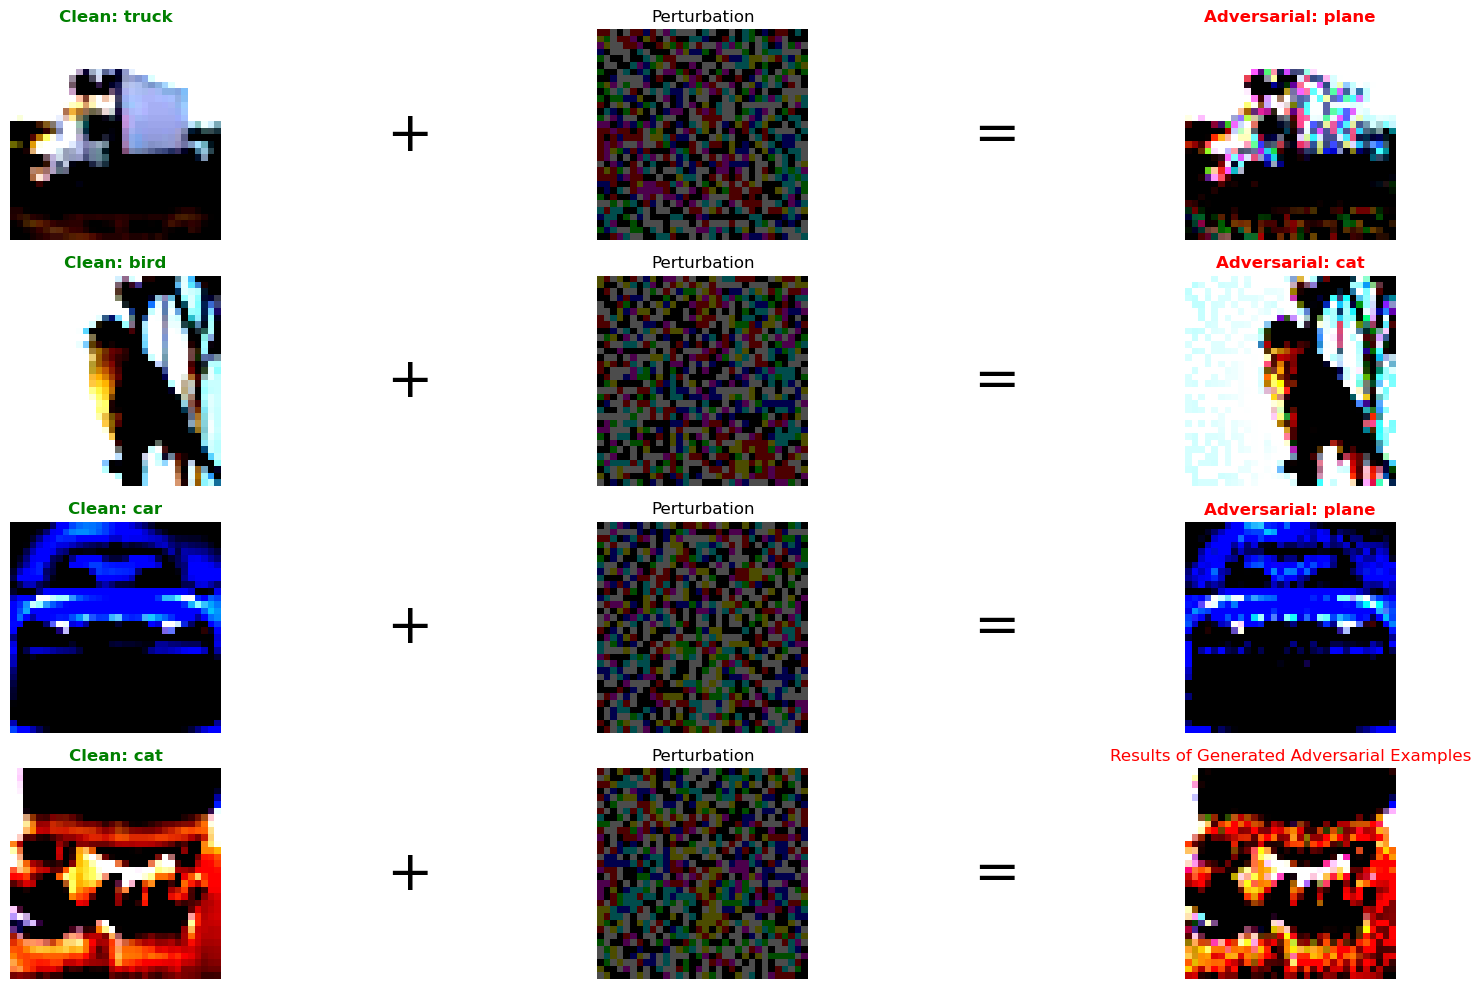

In [12]:
if __name__ == '__main__':
    main(train_model=True)
    main(train_model=False)